Date Created: 10/25/20
## Goal of Notebook: Create Markov Chain of Genome Ordering
Build a markov of genome ordering. Where states are genes and state transition represent adjancenies

In [1]:
import requests 
import pandas as pd
from random import sample 
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns                                                             
import sys 
from networkx.algorithms import bipartite
from networkx.algorithms.community import greedy_modularity_communities

Load in phage dataframes

In [2]:
df_phages = pd.read_csv("data/phage_metadata.csv")
df_phages.head()

,phage,temperate,cluster,subcluster,morphotype,host genus,host species,genome length,is annotated,is phamerated,gcpercent
0,20ES,True,A,A2,SIPHO,Mycobacterium,smegmatis,53124.0,False,True,63.4
1,244,True,E,NaN,SIPHO,Mycobacterium,smegmatis,74483.0,True,True,63.4
2,32HC,True,Z,NaN,SIPHO,Mycobacterium,smegmatis,50781.0,False,True,65.7
3,39HC,False,B,B6,SIPHO,Mycobacterium,smegmatis,71565.0,False,True,70.0
4,40AC,True,A,A17,SIPHO,Mycobacterium,smegmatis,53396.0,False,True,63.3


In [3]:
df_genes = pd.read_csv("data/cleaned_gene_list.csv")
df_genes.head()

,gene ID,pham,function,translation,orientation,phage,gene number,uncleaned function
0,20ES_CDS_1,36676,NKF,MYGTRSSAFWASQPGKFDVLNLRMTFPSTSAHEIPDLTATDFVPEN...,F,20ES,1,NaN
1,20ES_CDS_10,39578,lysin b,MSLQVGSSGELVNRWIRVMKARFASYAGKLKEDGYFGLDDKAVQQE...,F,20ES,10,lysin b
2,20ES_CDS_11,34196,terminase,MSLENHHPELAPSPPHIIGPSWQRTVDGSWHLPDPKMTLGWGVLKW...,F,20ES,11,terminase
3,20ES_CDS_12,39511,portal protein,MTAPLPGQEEIPDPAIARDEMISAFDDAVKNLKINTSYYEAERRPE...,F,20ES,12,portal protein
4,20ES_CDS_13,21454,capsid maturation protease,MITAAVAAYVQRFASMFTGPALSLGEWARFLQTLFPEVQRRYAQAA...,F,20ES,13,capsid maturation protease


Create markov chain where states are the "gene identifier" is function of the gene, making NKF genes one node

In [36]:
gene_identifier = "pham" # identify what makes a gene unique

In [37]:
phages = df_phages["phage"].unique()

# all unique labels, ie functions or phams
labels = ["5' start"] + [ident for ident in np.sort(df_genes[gene_identifier].unique())] + ["3' end"]
label_to_index = { labels[i]:i for i in range(len(labels))} # coversion to index for transition matrix

# initialize transition matrix for counts
transition_counts = np.zeros((len(labels),len(labels)))

# for all phages, then for all genes in the phage add counts
for phage in phages:
    phage_df = df_genes[df_genes["phage"] == phage].sort_values(by=['gene number'])
    i = label_to_index["5' start"]
    for index, row in phage_df.iterrows(): 
        j = label_to_index[row[gene_identifier]]
        transition_counts[i][j] += 1
        i = j
    transition_counts[i][label_to_index["3' end"]] += 1
    
# use count matrix to probabilties by dividing by row
transition_matrix = np.zeros((len(labels),len(labels)))
for i in range(len(labels)):
    sum_row = np.sum(transition_counts[i][:])
    transition_matrix[i][:] = transition_counts[i][:]/(sum_row if sum_row > 0 else 1)

Relabel nodes into pham instead of their indices

In [38]:
# create a network from the transition matrix
G_markov = nx.from_numpy_matrix(transition_matrix, create_using=nx.DiGraph)
index_to_label = {j:str(i) for i,j in label_to_index.items()}
G_markov = nx.relabel_nodes(G_markov, index_to_label)

Add node counts, ie the amount of apperance of that gene in the dataset

In [39]:

if gene_identifier == "pham":
    df_pham_counts = df_genes.groupby("pham",as_index=False).count()

    for pham in G_markov.nodes():
        #G_markov.nodes[pham] = df_pham_counts[df_pham_counts["pham"]==int(pham)].values
        if pham.isnumeric():
            G_markov.nodes[pham]["count"] = df_pham_counts[df_pham_counts["pham"]==int(pham)]["gene ID"].values[0]
            
else:
    df_function_counts = df_genes.groupby("function",as_index=False).count()
    for fun in G_markov.nodes():
        if fun not in ["5' start","3' end"]:
            G_markov.nodes[fun]["count"] = df_function_counts[df_function_counts["function"]==fun]["gene ID"].values[0]
        else:
            G_markov.nodes[fun]["count"] = 1
            

In [49]:
if gene_identifier == "function":
    pos = nx.random_layout(G_markov)
    node_size = [G_markov.nodes[i]["count"]**0.5 if i not in ["5' start","3' end"] else 1 for i in G_markov.nodes()]
    plt.figure(figsize=(15,15))

    nx.draw_networkx_nodes(G_markov,
                           pos = pos,
                           node_size = node_size
                            )
    nx.draw_networkx_edges(G_markov,
                           pos = pos,
                           node_size = node_size,
                           alpha = 0.1
                           )
    sns.despine(bottom=True, left = True)
    plt.show()

In [45]:
print("mean degree:", G_markov.size()*2/len(G_markov.nodes()))
print("# edges:", G_markov.size())
print("# nodes:", len(G_markov.nodes()))

mean degree: 3.8706621889262034
# edges: 44950
# nodes: 23226


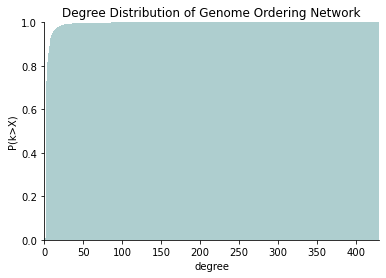

In [48]:
degs = [j for i,j in G_markov.degree()]
plt.hist(degs , bins = 1000, density = True, cumulative=True, alpha = 0.5, color = "cadetblue", label = "degree")
plt.xlim(left = 0, right = max(degs))
plt.ylim(top=1)
plt.xlabel("degree")
plt.ylabel("P(k>X)")
plt.title("Degree Distribution of Genome Ordering Network")
sns.despine()
plt.show()

save network for use in other notebooks

In [15]:
nx.write_gml(G_markov,"networks/synteny_markov_graph_"+gene_identifier, stringizer = str)

What can we learn from communtity detection on this matricies? Do we pull out core genome regions?

In [16]:
groupings = greedy_modularity_communities(G_markov, weight=None)

for g in range(30):
    print("GROUP ",g)
    for i in groupings[g]:
        print(labels[i])
    print()

KeyError: (-0.00502460769409158, 149, 150)

Creating a new heuristic for synteny. It is not just important that P(i->j) is high but also that it is an observe transition. How do you identify a random insertion versus a unique genome that we haven't seen before?